In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install fiona
!pip install rasterio

     |████████████████████████████████| 14.7MB 48.6MB/s 
     |████████████████████████████████| 18.1MB 244kB/s 


In [0]:
import sys
sys.path.append('/content/drive/My Drive/Weak_Learners_ML2020')

In [0]:
import scipy
import numpy as np
import seaborn as sns
import fiona
import rasterio
import matplotlib.pyplot as plt

from shapely import geometry
from rasterio.mask import mask
from tqdm import tqdm_notebook
from extractor_helper import extractor
from torchvision import transforms

import torch
import torch.nn


import utils2   ###############################3
from utils2 import get_accuracy, Monitor, set_random_seeds, f1_score_ ##############
from tqdm import trange
import random

from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
import torchvision.utils as vutils
from sklearn.utils import shuffle

from extractor_helper import extractor
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.utils.data as torch_data

from torchvision.models import resnet18

import argparse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
test2_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/pp_2_sat_modified.tif")
test2_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test2/points_2_modified_Copy.shp", "r")

test3_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/pp_3_sat_modified.tif")
test3_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test3/targets_Copy.shp", "r")

test4_img = rasterio.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/pp_4_sat_modified_spline.tif")
test4_points = fiona.open("/content/drive/My Drive/Weak_Learners_ML2020/Eval/test4/modified_points_Copy.shp", "r")

patch2,coordinates2,labels2, = extractor(test2_img,test2_points,size=15,normalize=True,labeling=True)
patch3,coordinates3,labels3, = extractor(test3_img,test3_points,size=15,normalize=True,labeling=True)
patch4,coordinates4,labels4, = extractor(test4_img,test4_points,size=15,normalize=True,labeling=True)


patch2,patch3, patch4 = np.array(patch2), np.array(patch3), np.array(patch4)
labels2, labels3, labels4 = np.array(labels2), np.array(labels3), np.array(labels4)
patch2, patch3, patch4 = np.moveaxis(patch2,3,1), np.moveaxis(patch3,3,1), np.moveaxis(patch4,3,1)

patches = np.concatenate((patch2, patch3, patch4),axis=0)
labels = np.concatenate((labels2,labels3,labels4),axis=0)

None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coordinate/close to edge
None coord

In [0]:
x_train,x_test,y_train,y_test = train_test_split(patches, labels, test_size=.2, shuffle=True, random_state = 12) 

In [0]:
class TreesData(Dataset):
    def __init__(self, X, y, flip=0, duplicate={}):
        super().__init__()

        for k, v in duplicate.items():
          idx = y == k
          X = np.concatenate([X, np.repeat(X[idx], int(v), 0)])
          y = np.concatenate([y, np.repeat(y[idx], int(v), 0)])
        self.X, self.y = shuffle(X, y)
        self.flip = flip

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
      x = self.X[idx]
      y = self.y[idx]
      if random.random() < self.flip:
        x = np.flip(x, (1,))
      if random.random() < self.flip:
        x = np.flip(x, (2,))
 
      # --- optional code ---
      #if self.flip > 0:
      #  x = rotate(x, random.random() * 360, (1, 2), reshape=False)
      #  x = zoom(x, 1 + (random.random() * 0.2 - 0.1))
      #x = x[:, 2:-2, 2:-2]
      return torch.tensor(np.array(x), dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [0]:
weight_0 = len(labels) / np.sum(labels == 0)
weight_1 = len(labels) / np.sum(labels == 1)
weight_2 = len(labels) / np.sum(labels == 2)
weight_3 = len(labels) / np.sum(labels == 3)
print(weight_0, weight_1, weight_2, weight_3)
duplicate = {0: round(weight_0 - 1), 1: round(weight_1 - 1), 2: round(weight_2 -1), 3: round(weight_3 -1)}
weight = np.array([weight_0, weight_1, weight_2, weight_3])
weight = weight / np.sum(weight) # normalized, just in case this is not done automatically

1.9536679536679538 3.212698412698413 24.095238095238095 7.386861313868613


In [0]:
train_data = TreesData(x_train,y_train,0.5,duplicate)
test_data = TreesData(x_test,y_test)

In [0]:
fff = x_train[0].copy()
fff = np.array([[[2,1,9],[6,7,8],[5,0,8]],[[0,7,2],[7,5,1],[2,7,22]]])
fff


array([[[ 2,  1,  9],
        [ 6,  7,  8],
        [ 5,  0,  8]],

       [[ 0,  7,  2],
        [ 7,  5,  1],
        [ 2,  7, 22]]])

In [0]:
np.flip(fff, (1,))

array([[[ 5,  0,  8],
        [ 6,  7,  8],
        [ 2,  1,  9]],

       [[ 2,  7, 22],
        [ 7,  5,  1],
        [ 0,  7,  2]]])

In [0]:
train_loader = torch_data.DataLoader(train_data,batch_size=64, shuffle=True, num_workers=16)
val_loader = torch_data.DataLoader(test_data,batch_size=512,shuffle=True, num_workers=2)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
def train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1, plot_each=10):
    # send the model to that device
    model = model.to(device)
    # initialize some visualization code that you don't need to care about
    monitor = Monitor()
    # Reduce the lr every 50 epochs
    #scheduler = StepLR(optimizer, 50, 0.5, last_epoch=-1)
    # one full cycle on train data is called epoch
    for epoch in trange(epochs_n):
        # switch the model to the train mode
        # later on we will have some blocks that behave differently in train and test mode
        model.train()
        for model_input, target in train_loader:
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # do some visualization
            monitor.add_loss_value(loss.item())
        
        # evaluate our model
        model.eval()
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)

        val_f1 = f1_score_(model, val_loader, device)  ###########

        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        monitor.add_val_f1_value(val_f1)  ##############

    
        #scheduler.step()
        
        if epoch % plot_each == 0:
            monitor.show()

In [0]:
import torch.nn.functional as F
class CNNClassifier(nn.Module):

    def __init__(self, channels=8 , num_classes=4):
        super(CNNClassifier, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.drop_layer_conv = nn.Dropout(p=0.25)
        self.drop_layer_dense = nn.Dropout(p=0.5)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(64 * 7 * 7, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

    def forward(self, x):
      # Block 1
      x = F.relu(self.conv1(x))
      x = F.relu(self.conv2(x))
      x = self.pool(x)
      x = self.drop_layer_conv(x)
      # Block 2
      x = F.relu(self.conv3(x))
      x = F.relu(self.conv4(x))
      x = self.pool(x)
      x = self.drop_layer_conv(x)
      #print(x.shape)
      x = x.view(-1, 64 * 7 * 7)
      x = F.relu(self.fc1(x))
      x = self.drop_layer_dense(x)
      x = self.fc2(x)



      return x

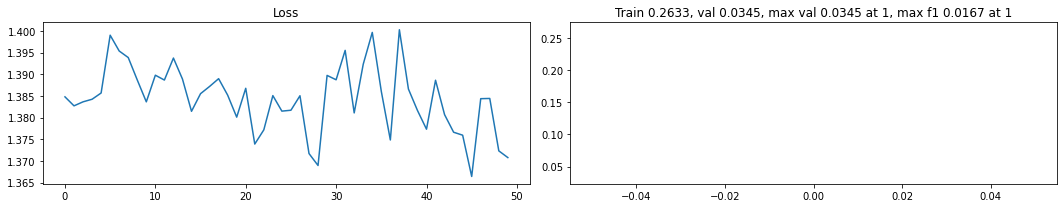

  2%|▏         | 10/500 [02:56<2:22:54, 17.50s/it]

In [0]:
model = CNNClassifier()
loss_function = torch.nn.CrossEntropyLoss()#weight = torch.FloatTensor(weight).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500)


In [0]:
random.random()

0.6067606085584131